# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

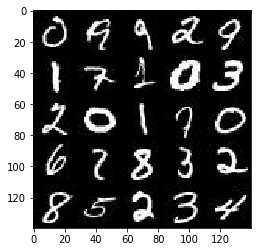

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

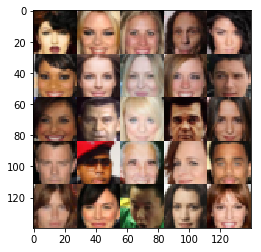

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [96]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 3, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        #conv2 = tf.nn.relu(conv2)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 3, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        #conv3 = tf.nn.relu(conv3)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        size = conv3.get_shape().as_list()
        n = size[1] * size[2] * size[3]
        flat = tf.reshape(conv3, [-1, n])
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [97]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 3 * 3 * 256)
        x1 = tf.reshape(x1, [-1, 3, 3, 256])    
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.nn.relu(x1)
        x1 = tf.maximum(alpha*x1, x1)
        
        #x2 = tf.image.resize_nearest_neighbor(x1, (7,7))
        #x2 = tf.layers.conv2d(x2, 256, 5, padding='same')
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #x2 = tf.nn.relu(x2)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.nn.relu(x3)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', activation=None)
        logits = tf.tanh(logits)

    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [98]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
 
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(   g_model, reuse=True)

    d_label_real = tf.ones_like(d_model_real) * 0.9
    d_label_fake = tf.zeros_like(d_model_fake)
    g_label_fake = tf.ones_like(d_model_fake)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_label_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_label_fake))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_label_fake))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [99]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [100]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [106]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()

    image_channels = data_shape[3]
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z}) 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                if step % 10 == 0:
                    d_loss_out = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    g_loss_out = sess.run(g_loss, feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_out),
                                 "Generator Loss: {:.4f}".format(g_loss_out))
                if step % 100 == 0:
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)
    print("Finished training ...")
    #saver.save(sess, './checkpoints/generator.ckpt')         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(128, 28, 28, 1)
[[[-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.46862745]
  [-0.5       ]
  [-0.5       ]
  [-0.43333334]
  [-0.5       ]
  [-0.45294118]
  [-0.5       ]
  [-0.48431373]
  [-0.48039216]
  [-0.5       ]
  [-0.5       ]
  [-0.43725491]
  [-0.48039216]
  [-0.5       ]
  [-0.49215686]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.48431373]
  [-0.5       ]
  [-0.46470588]
  [-0.49607843]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.48431373]
  [-0.5       ]
  [-0.5       ]
  [-0.46078432]
  [-0.49215686]
  [-0.5       ]
  [-0.5       ]
  [-0.44901961]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]]

 [[-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [-0.5       ]
  [

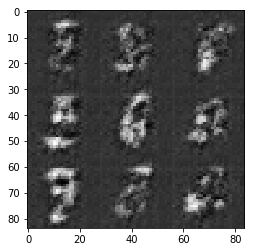

Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.5200... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 1.9414... Generator Loss: 0.2451
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 3.0566
Epoch 1/2... Discriminator Loss: 1.7904... Generator Loss: 0.3082
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 1.2163
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.7277... Generator Loss: 1.4604


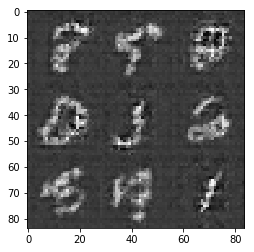

Epoch 1/2... Discriminator Loss: 0.9894... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 2.1385... Generator Loss: 0.2112
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 1.1220


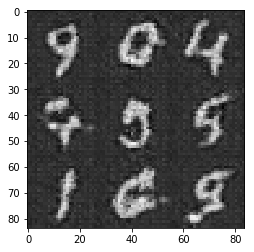

Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 2.6208
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.7312
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.0865
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 1.8774
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 1.7761
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 2.4269
Epoch 1/2... Discriminator Loss: 1.4751... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.9411


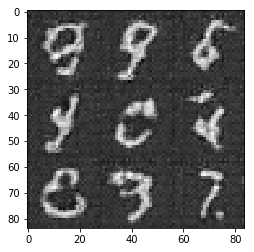

Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.5616... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 2.6025... Generator Loss: 3.6586
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 2.1745... Generator Loss: 0.1946
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 1.5564
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 1.6401


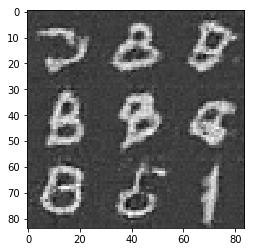

Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 2.2469
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.4890
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 1.4068
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 2.8369
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.4380
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 3.8007


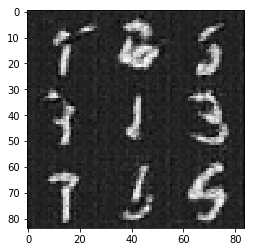

Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.6409... Generator Loss: 2.0875
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.6369
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 1.6358... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 2.9930... Generator Loss: 1.2292
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.0302
Epoch 2/2... Discriminator Loss: 1.5821... Generator Loss: 0.3812


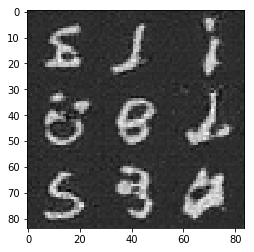

Epoch 2/2... Discriminator Loss: 1.7052... Generator Loss: 0.3276
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.3605
Epoch 2/2... Discriminator Loss: 1.4690... Generator Loss: 0.4425
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 2.0072
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 1.5295... Generator Loss: 1.6848
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 2.7045
Epoch 2/2... Discriminator Loss: 1.5071... Generator Loss: 0.4354
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.4817


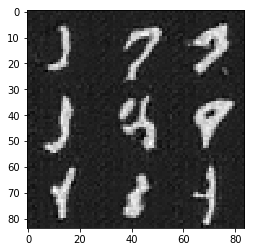

Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 0.8564... Generator Loss: 1.7777
Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 0.3788
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 4.3701... Generator Loss: 3.5603
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 1.3054
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.4703... Generator Loss: 0.4381


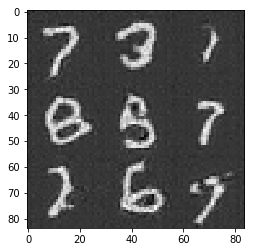

Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 3.0857
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.7022
Finished training ...


In [107]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(128, 28, 28, 3)
[[[-0.33137256 -0.40980393 -0.45686275]
  [-0.31176472 -0.40588236 -0.46078432]
  [-0.29607844 -0.4137255  -0.46862745]
  ..., 
  [-0.46862745 -0.46862745 -0.48431373]
  [-0.46470588 -0.47254902 -0.48431373]
  [-0.46078432 -0.48039216 -0.48823529]]

 [[-0.28431374 -0.39803922 -0.45294118]
  [-0.28039217 -0.39411765 -0.46470588]
  [-0.24117646 -0.35882354 -0.44901961]
  ..., 
  [-0.46078432 -0.46078432 -0.47647059]
  [-0.45686275 -0.46862745 -0.48039216]
  [-0.45294118 -0.47254902 -0.48431373]]

 [[-0.29607844 -0.40588236 -0.47254902]
  [-0.25686276 -0.37843138 -0.46078432]
  [-0.21764705 -0.37058824 -0.46078432]
  ..., 
  [-0.44901961 -0.45294118 -0.46470588]
  [-0.44901961 -0.45686275 -0.46470588]
  [-0.46862745 -0.47647059 -0.48431373]]

 ..., 
 [[-0.39411765 -0.49215686 -0.48823529]
  [-0.38627452 -0.47254902 -0.47254902]
  [-0.38627452 -0.46470588 -0.46862745]
  ..., 
  [-0.40588236 -0.49607843 -0.48823529]
  [-0.38235295 -0.49215686 -0.48039216]
  [-0.38627452 -0.

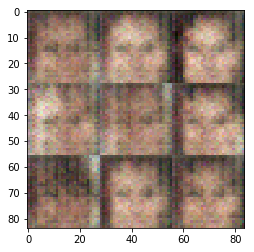

Epoch 1/1... Discriminator Loss: 1.8444... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.7686


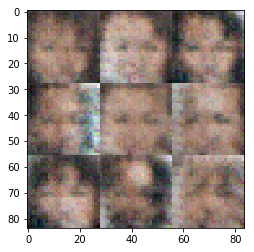

Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.8037... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7335


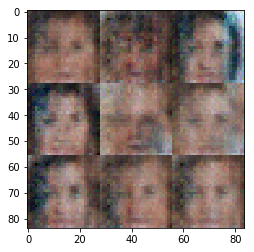

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.6667


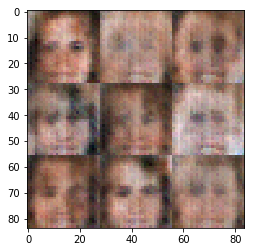

Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.6877... Generator Loss: 0.6297


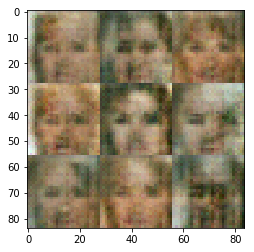

Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7830


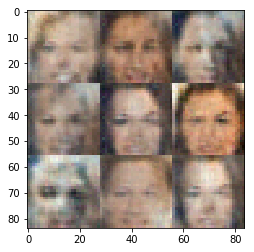

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7376


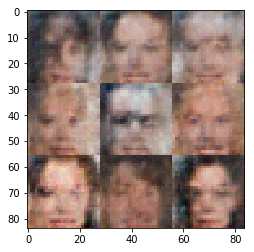

Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6488


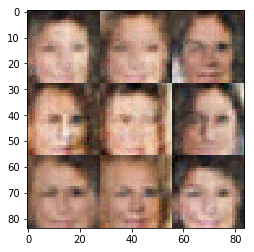

Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6146


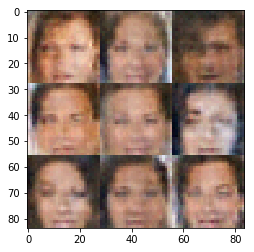

Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7501


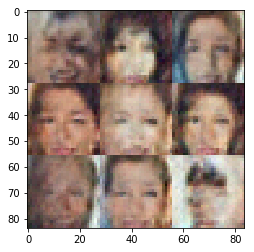

Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6470


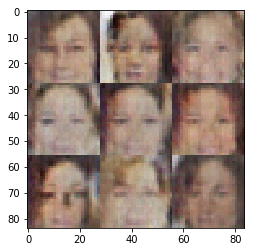

Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7450


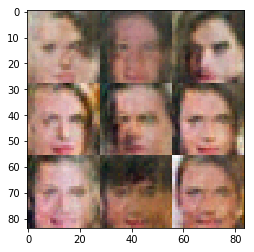

Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7052


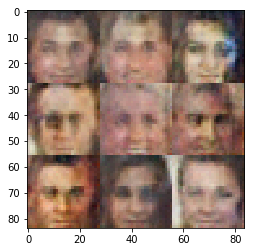

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6956


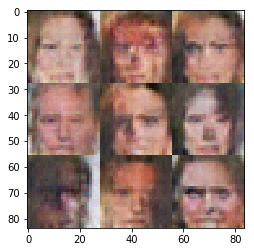

Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7732


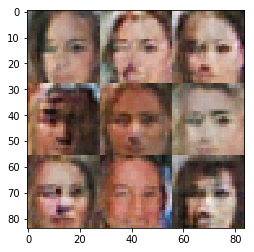

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7011
Finished training ...


In [108]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.